### PREDICT TIME SERIES USING XGBOOST

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
%matplotlib inline

In [3]:
train = pd.read_csv('./web-traffic-time-series-forecasting/train_1.csv').fillna(0)
train.head()

Page  2015-07-01  2015-07-02  \
0            2NE1_zh.wikipedia.org_all-access_spider        18.0        11.0   
1             2PM_zh.wikipedia.org_all-access_spider        11.0        14.0   
2              3C_zh.wikipedia.org_all-access_spider         1.0         0.0   
3         4minute_zh.wikipedia.org_all-access_spider        35.0        13.0   
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...         0.0         0.0   

   2015-07-03  2015-07-04  2015-07-05  2015-07-06  2015-07-07  2015-07-08  \
0         5.0        13.0        14.0         9.0         9.0        22.0   
1        15.0        18.0        11.0        13.0        22.0        11.0   
2         1.0         1.0         0.0         4.0         0.0         3.0   
3        10.0        94.0         4.0        26.0        14.0         9.0   
4         0.0         0.0         0.0         0.0         0.0         0.0   

   2015-07-09  ...  2016-12-22  2016-12-23  2016-12-24  2016-12-25  \
0        26.0  ...        32.0        63.0        15.0        26.0   
1        10.0  ...        17.0        42.0        28.0        15.0   
2         4.0  ...         3.0         1.0         1.0         7.0   
3        11.0  ...        32.0        10.0        26.0        27.0   
4         0.0  ...        48.0         9.0        25.0        13.0   

   2016-12-26  2016-12-27  2016-12-28  2016-12-29  2016-12-30  2016-12-31  
0        14.0        20.0        22.0        19.0        18.0        20.0  
1         9.0        30.0        52.0        45.0        26.0        20.0  
2         4.0         4.0         6.0         3.0         4.0        17.0  
3        16.0        11.0        17.0        19.0        10.0        11.0  
4         3.0        11.0        27.0        13.0        36.0        10.0  

[5 rows x 551 columns]

In [4]:
train.Page.head()

0              2NE1_zh.wikipedia.org_all-access_spider
1               2PM_zh.wikipedia.org_all-access_spider
2                3C_zh.wikipedia.org_all-access_spider
3           4minute_zh.wikipedia.org_all-access_spider
4    52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...
Name: Page, dtype: object

In [5]:
res = re.search('[a-z][a-z].wikipedia.org','2NE1_zh.wikipedia.org_all-access_spider')

In [6]:
print(res[0])

zh.wikipedia.org


In [7]:
def get_language(page):
    res = re.search('[a-z][a-z].wikipedia.org',page)
    if res:
        return res[0][0:2]
    return 'na'

train['lang'] = train.Page.map(get_language)

from collections import Counter

print(Counter(train.lang))

Counter({'en': 24108, 'ja': 20431, 'de': 18547, 'na': 17855, 'fr': 17802, 'zh': 17229, 'ru': 15022, 'es': 14069})


In [8]:
train[train.lang=='en'].head()

Page  2015-07-01  \
8357          !vote_en.wikipedia.org_desktop_all-agents         3.0   
8358  "Awaken,_My_Love!"_en.wikipedia.org_desktop_al...         0.0   
8359  "European_Society_for_Clinical_Investigation"_...         0.0   
8360  "Weird_Al"_Yankovic_en.wikipedia.org_desktop_a...      2403.0   
8361     100_metres_en.wikipedia.org_desktop_all-agents       982.0   

      2015-07-02  2015-07-03  2015-07-04  2015-07-05  2015-07-06  2015-07-07  \
8357         4.0         7.0         4.0         4.0         2.0         3.0   
8358         0.0         0.0         0.0         0.0         0.0         0.0   
8359         0.0         0.0         0.0         0.0         0.0         0.0   
8360     20136.0      1850.0      1432.0      1351.0      1792.0      1710.0   
8361       881.0       794.0       979.0      1191.0      1057.0      1184.0   

      2015-07-08  2015-07-09  ...  2016-12-23  2016-12-24  2016-12-25  \
8357         7.0         2.0  ...         1.0         6.0         3.0   
8358         0.0         0.0  ...      2676.0      2032.0      2294.0   
8359         0.0         1.0  ...         0.0         0.0         0.0   
8360      2039.0      1957.0  ...      1238.0       976.0       810.0   
8361       860.0      1259.0  ...       344.0       225.0       229.0   

      2016-12-26  2016-12-27  2016-12-28  2016-12-29  2016-12-30  2016-12-31  \
8357         1.0         1.0         3.0         3.0         1.0         0.0   
8358      2074.0      2175.0      2156.0      2302.0      2098.0      1770.0   
8359         0.0         0.0         0.0         0.0         1.0         2.0   
8360       989.0      1332.0      1243.0      1681.0      1303.0      1098.0   
8361       335.0       313.0       379.0       393.0       354.0       272.0   

      lang  
8357    en  
8358    en  
8359    en  
8360    en  
8361    en  

[5 rows x 552 columns]

In [9]:
lang_sets = {}
lang_sets['en'] = train[train.lang=='en'].iloc[:,0:-1]
lang_sets['ja'] = train[train.lang=='ja'].iloc[:,0:-1]
lang_sets['de'] = train[train.lang=='de'].iloc[:,0:-1]
lang_sets['na'] = train[train.lang=='na'].iloc[:,0:-1]
lang_sets['fr'] = train[train.lang=='fr'].iloc[:,0:-1]
lang_sets['zh'] = train[train.lang=='zh'].iloc[:,0:-1]
lang_sets['ru'] = train[train.lang=='ru'].iloc[:,0:-1]
lang_sets['es'] = train[train.lang=='es'].iloc[:,0:-1]

sums = {}
for key in lang_sets:
    #print(lang_sets[key].shape[0])
    sums[key] = lang_sets[key].iloc[:,1:].sum(axis=0) / lang_sets[key].shape[0]
    #print(lang_sets[key].iloc[:,1:].sum(axis=0))
    #print(sums[key])

In [ ]:
# print(sums)

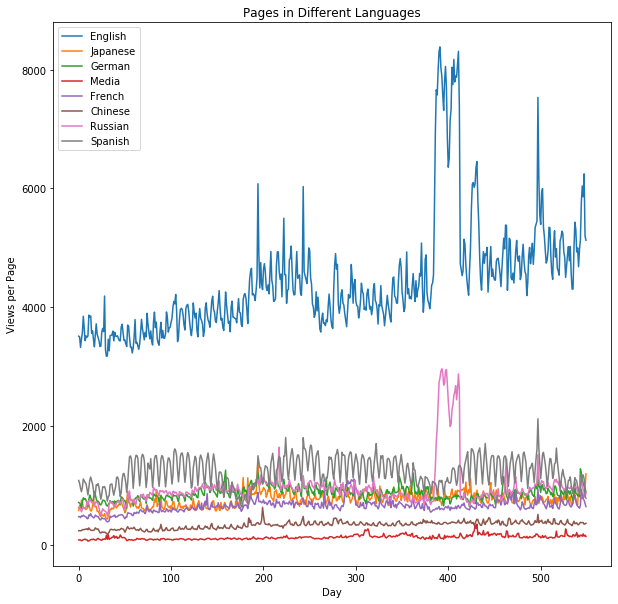

In [11]:
days = [r for r in range(sums['en'].shape[0])]

fig = plt.figure(1,figsize=[10,10])
plt.ylabel('Views per Page')
plt.xlabel('Day')
plt.title('Pages in Different Languages')
labels={'en':'English','ja':'Japanese','de':'German',
        'na':'Media','fr':'French','zh':'Chinese',
        'ru':'Russian','es':'Spanish'
       }

for key in sums:
    plt.plot(days,sums[key],label = labels[key] )
    
plt.legend()
plt.show()

en


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


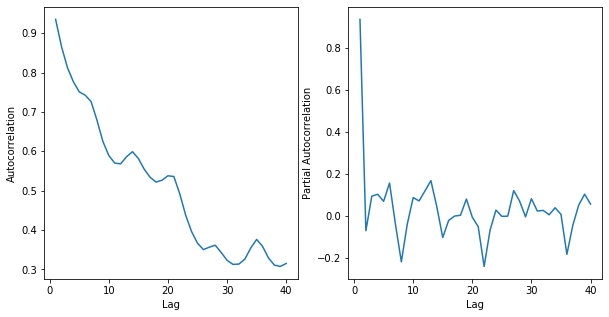

ja


de


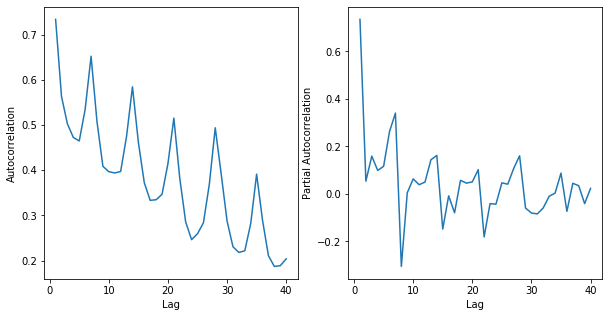

na


fr


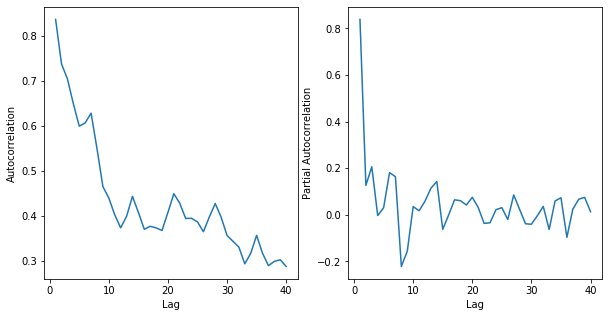

zh


ru


es


In [12]:
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf

for key in sums:
    fig = plt.figure(1,figsize=[10,5])
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    data = np.array(sums[key])
    autocorr = acf(data)
    pac = pacf(data)

    x = [x for x in range(len(pac))]
    ax1.plot(x[1:],autocorr[1:])

    ax2.plot(x[1:],pac[1:])
    ax1.set_xlabel('Lag')
    ax1.set_ylabel('Autocorrelation')

    ax2.set_xlabel('Lag')
    ax2.set_ylabel('Partial Autocorrelation')
    print(key)
    plt.show()

In [13]:
#Packages for pre processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

 # Importing the Keras libraries and packages for LSTM
from xgboost import XGBRegressor 

[01:07:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
en


[01:07:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
ja


[01:07:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
de


[01:07:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
na


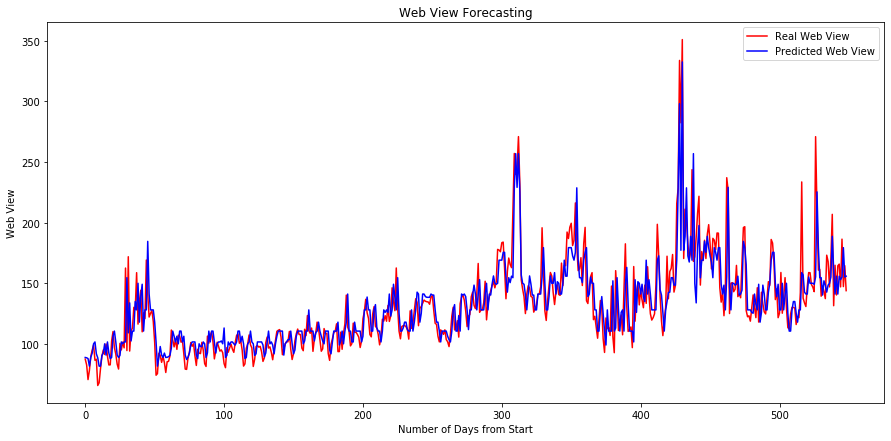

[01:07:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
fr


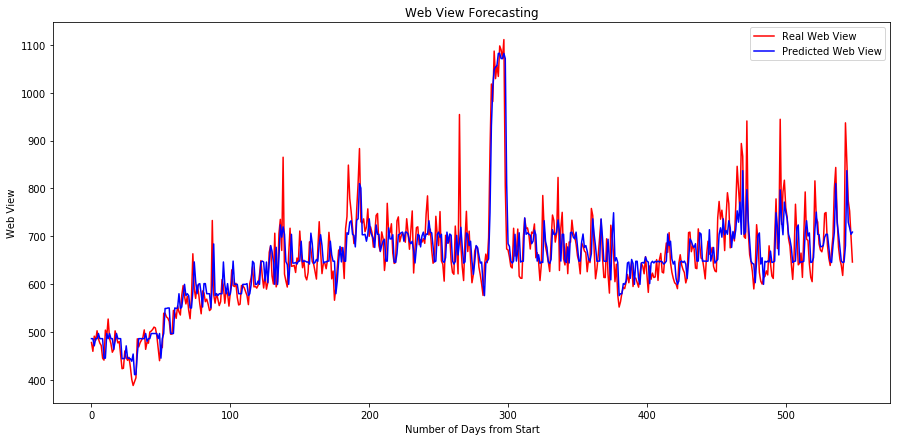

[01:07:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
zh


[01:07:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
ru


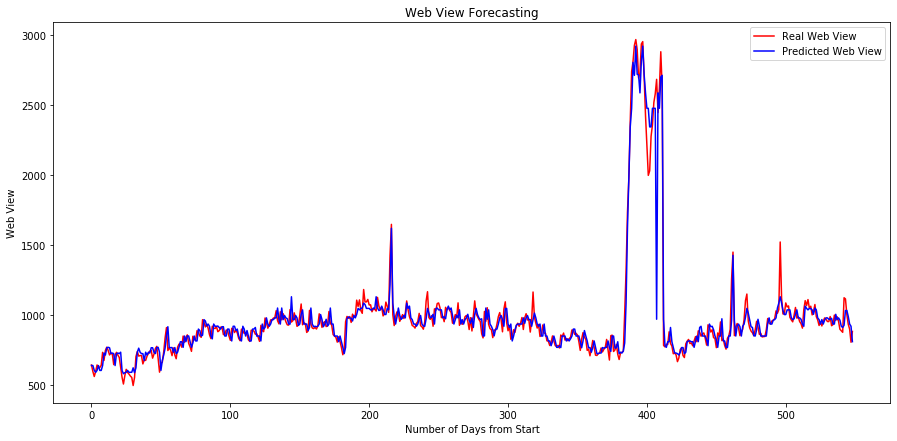

[01:07:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
es


In [36]:
for key in sums:
    row = [0]*sums[key].shape[0]
    for i in range(sums[key].shape[0]):
        row[i] = sums[key][i]


    #Using Data From Random Row for Training and Testing

    X = row[0:549]
    y = row[1:550]

    # Splitting the dataset into the Training set and Test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
    
    # Feature Scaling
    sc = MinMaxScaler()
    X_train = np.reshape(X_train,(-1,1))
    y_train = np.reshape(y_train,(-1,1))
    X_train = sc.fit_transform(X_train)
#     y_train = sc.fit_transform(y_train)
    
    #Training XGBOOST

    #Reshaping Array
#     X_train = np.reshape(X_train, (384,1,1))

    # Initialising XGBoost
    regressor = XGBRegressor()

    regressor.fit(X_train, y_train)

    # Getting the predicted Web View
    inputs = X
    inputs = np.reshape(inputs,(-1,1))
    inputs = sc.transform(inputs)
#     inputs = np.reshape(inputs, (549,1,1))
    y_pred = regressor.predict(inputs)
#     y_pred = sc.inverse_transform(y_pred)

    print(key)
    #Visualising Result
    plt.figure(figsize=(15, 7))
    plt.plot(y, color = 'red', label = 'Real Web View')
    plt.plot(y_pred, color = 'blue', label = 'Predicted Web View')
    plt.title('Web View Forecasting')
    plt.xlabel('Number of Days from Start')
    plt.ylabel('Web View')
    plt.legend()
    plt.show()